# TRANSFER LEARNING INCEPTION v3

- Try custom classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, utils, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)

Tensorflow version:  2.1.0
Keras version:  2.2.4-tf


In [4]:
image_shape = (299, 299, 3)
batch_size = 32
epoch = 50
seed_generator = 123
lr_init = 1e-4

In [5]:
def plot_training(history):
    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training acc")
    plt.plot(epochs, val_acc, label="valid acc")
    plt.title("Training & valid Accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="valid loss")
    plt.title("Training & valid Loss")
    plt.legend()
    plt.show()

#  Prepare dataset

In [6]:
base_dir = "aptos2019_balance_set_new_rescaled_300/"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "validation")

In [7]:
conv_base = InceptionV3(include_top=False,
                        weights="imagenet",
                        input_shape=image_shape)

conv_base.trainable = False
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
train_datagen = image.ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         fill_mode="reflect",
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         data_format="channels_last")

test_datagen = image.ImageDataGenerator(data_format="channels_last")

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape[0:2],
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed_generator)

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=image_shape[0:2],
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed_generator)

Found 750 images belonging to 5 classes.
Found 115 images belonging to 5 classes.


In [10]:
my_callbacks = [
    callbacks.CSVLogger("logging_classifier_keras_fastai.csv", append=True)
]

# Check Train Dataset

In [11]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [12]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

3

In [13]:
train_generator.filepaths[image_idx]

'aptos2019_balance_set_new_rescaled_300/train\\3_severe\\6d0c0531083f.png'

In [14]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

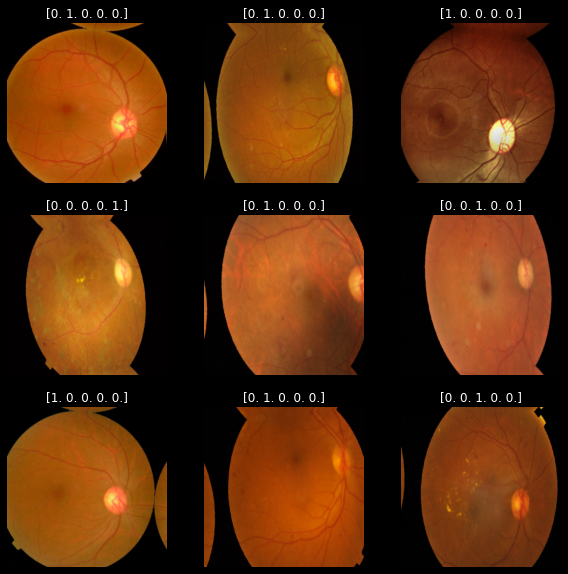

In [15]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis("off")

plt.show

# Check Validation Dataset

In [16]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [17]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

3

In [18]:
valid_generator.filepaths[image_idx]

'aptos2019_balance_set_new_rescaled_300/validation\\3_severe\\bf8092e4001d.png'

In [19]:
valid_images_7, valid_labels_7 = valid_generator[3]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


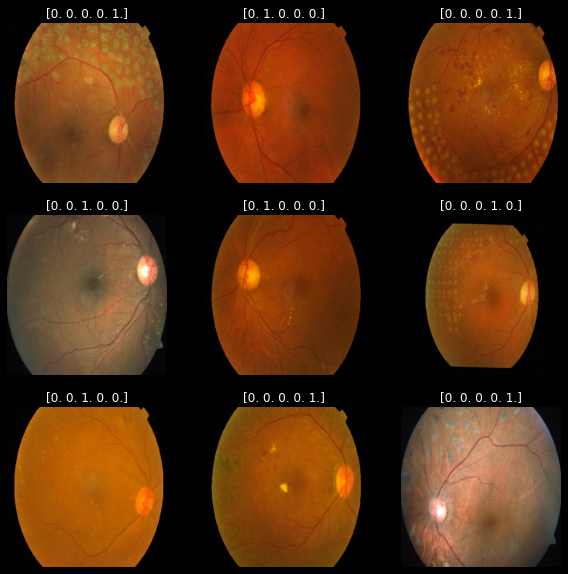

In [20]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis("off")

# Training Model

## Zhentao Gao's classifier / Keras

Source: https://ieeexplore.ieee.org/document/8581492

In [21]:
try:
    del (model)
except:
    pass

In [22]:
input_layer = keras.Input(shape=(image_shape))
x = preprocess_input(input_layer)
x = conv_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(5)(x)
output_layer = layers.Activation("softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=lr_init),
              metrics=["categorical_accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
_________________________________________________________________
activation_94 (Activation)   (None, 5)                 0     

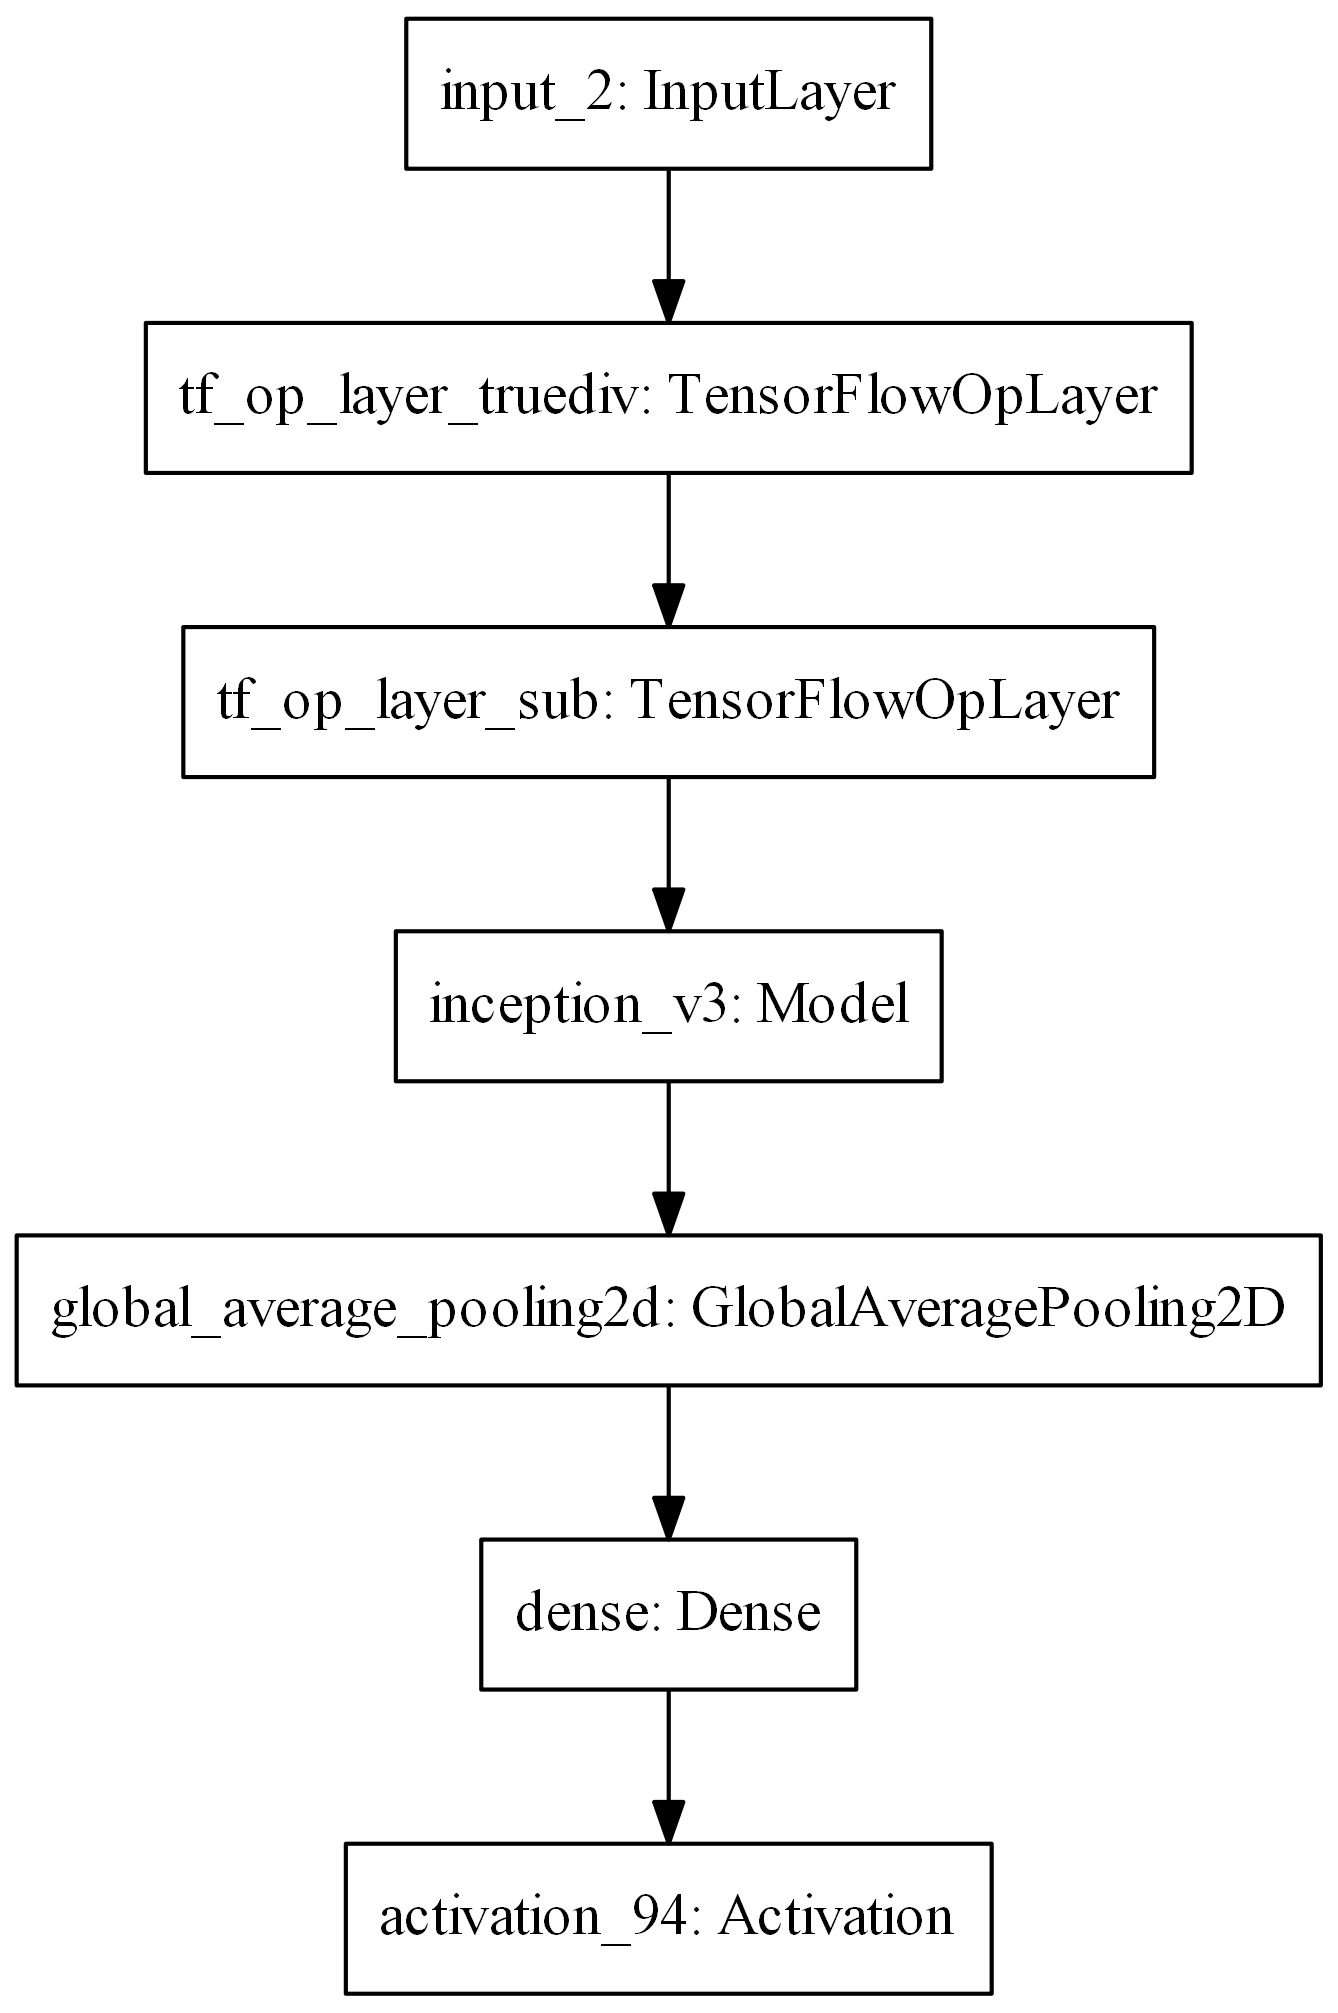

In [24]:
utils.plot_model(model, dpi=300)

In [25]:
history = model.fit(train_generator,
                    epochs=epoch,
                    validation_data=valid_generator,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/50
24/24 [==============================] - 63s 3s/step - loss: 1.6696 - categorical_accuracy: 0.1693 - val_loss: 1.6291 - val_categorical_accuracy: 0.2261
Epoch 2/50
24/24 [==============================] - 40s 2s/step - loss: 1.6080 - categorical_accuracy: 0.2787 - val_loss: 1.5829 - val_categorical_accuracy: 0.2348
Epoch 3/50
24/24 [==============================] - 39s 2s/step - loss: 1.5445 - categorical_accuracy: 0.3187 - val_loss: 1.5485 - val_categorical_accuracy: 0.3130
Epoch 4/50
24/24 [==============================] - 43s 2s/step - loss: 1.5098 - categorical_accuracy: 0.3573 - val_loss: 1.5144 - val_categorical_accuracy: 0.3304
Epoch 5/50
24/24 [==============================] - 38s 2s/step - loss: 1.4641 - categorical_accuracy: 0.3747 - val_loss: 1.4830 - val_categorical_accuracy: 0.3652
Epoch 6/50
24/24 [==============================] - 39s 2s/step - loss: 1.4340 - categori

In [26]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
4/4 [==============================] - 2s 503ms/step - loss: 1.1260 - categorical_accuracy: 0.5217


[1.1260186731815338, 0.5217391]

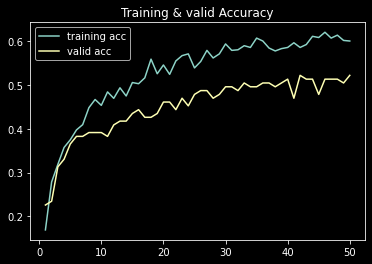

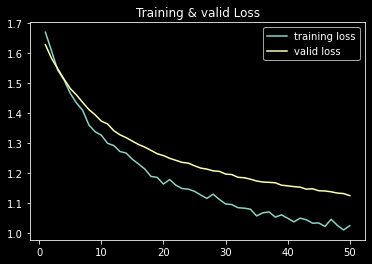

In [27]:
plot_training(history)

## Fast.ai Classifier

Source: https://fastai1.fast.ai/vision.learner.html#cnn_learner


In [28]:
try:
    del (model)
except:
    pass

In [29]:
input_layer = keras.Input(shape=(image_shape))
x = preprocess_input(input_layer)
x = conv_base(x, training=False)
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([x1, x2])
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Activation("relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5)(x)
output_layer = layers.Activation("softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [30]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=lr_init),
              metrics=["categorical_accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

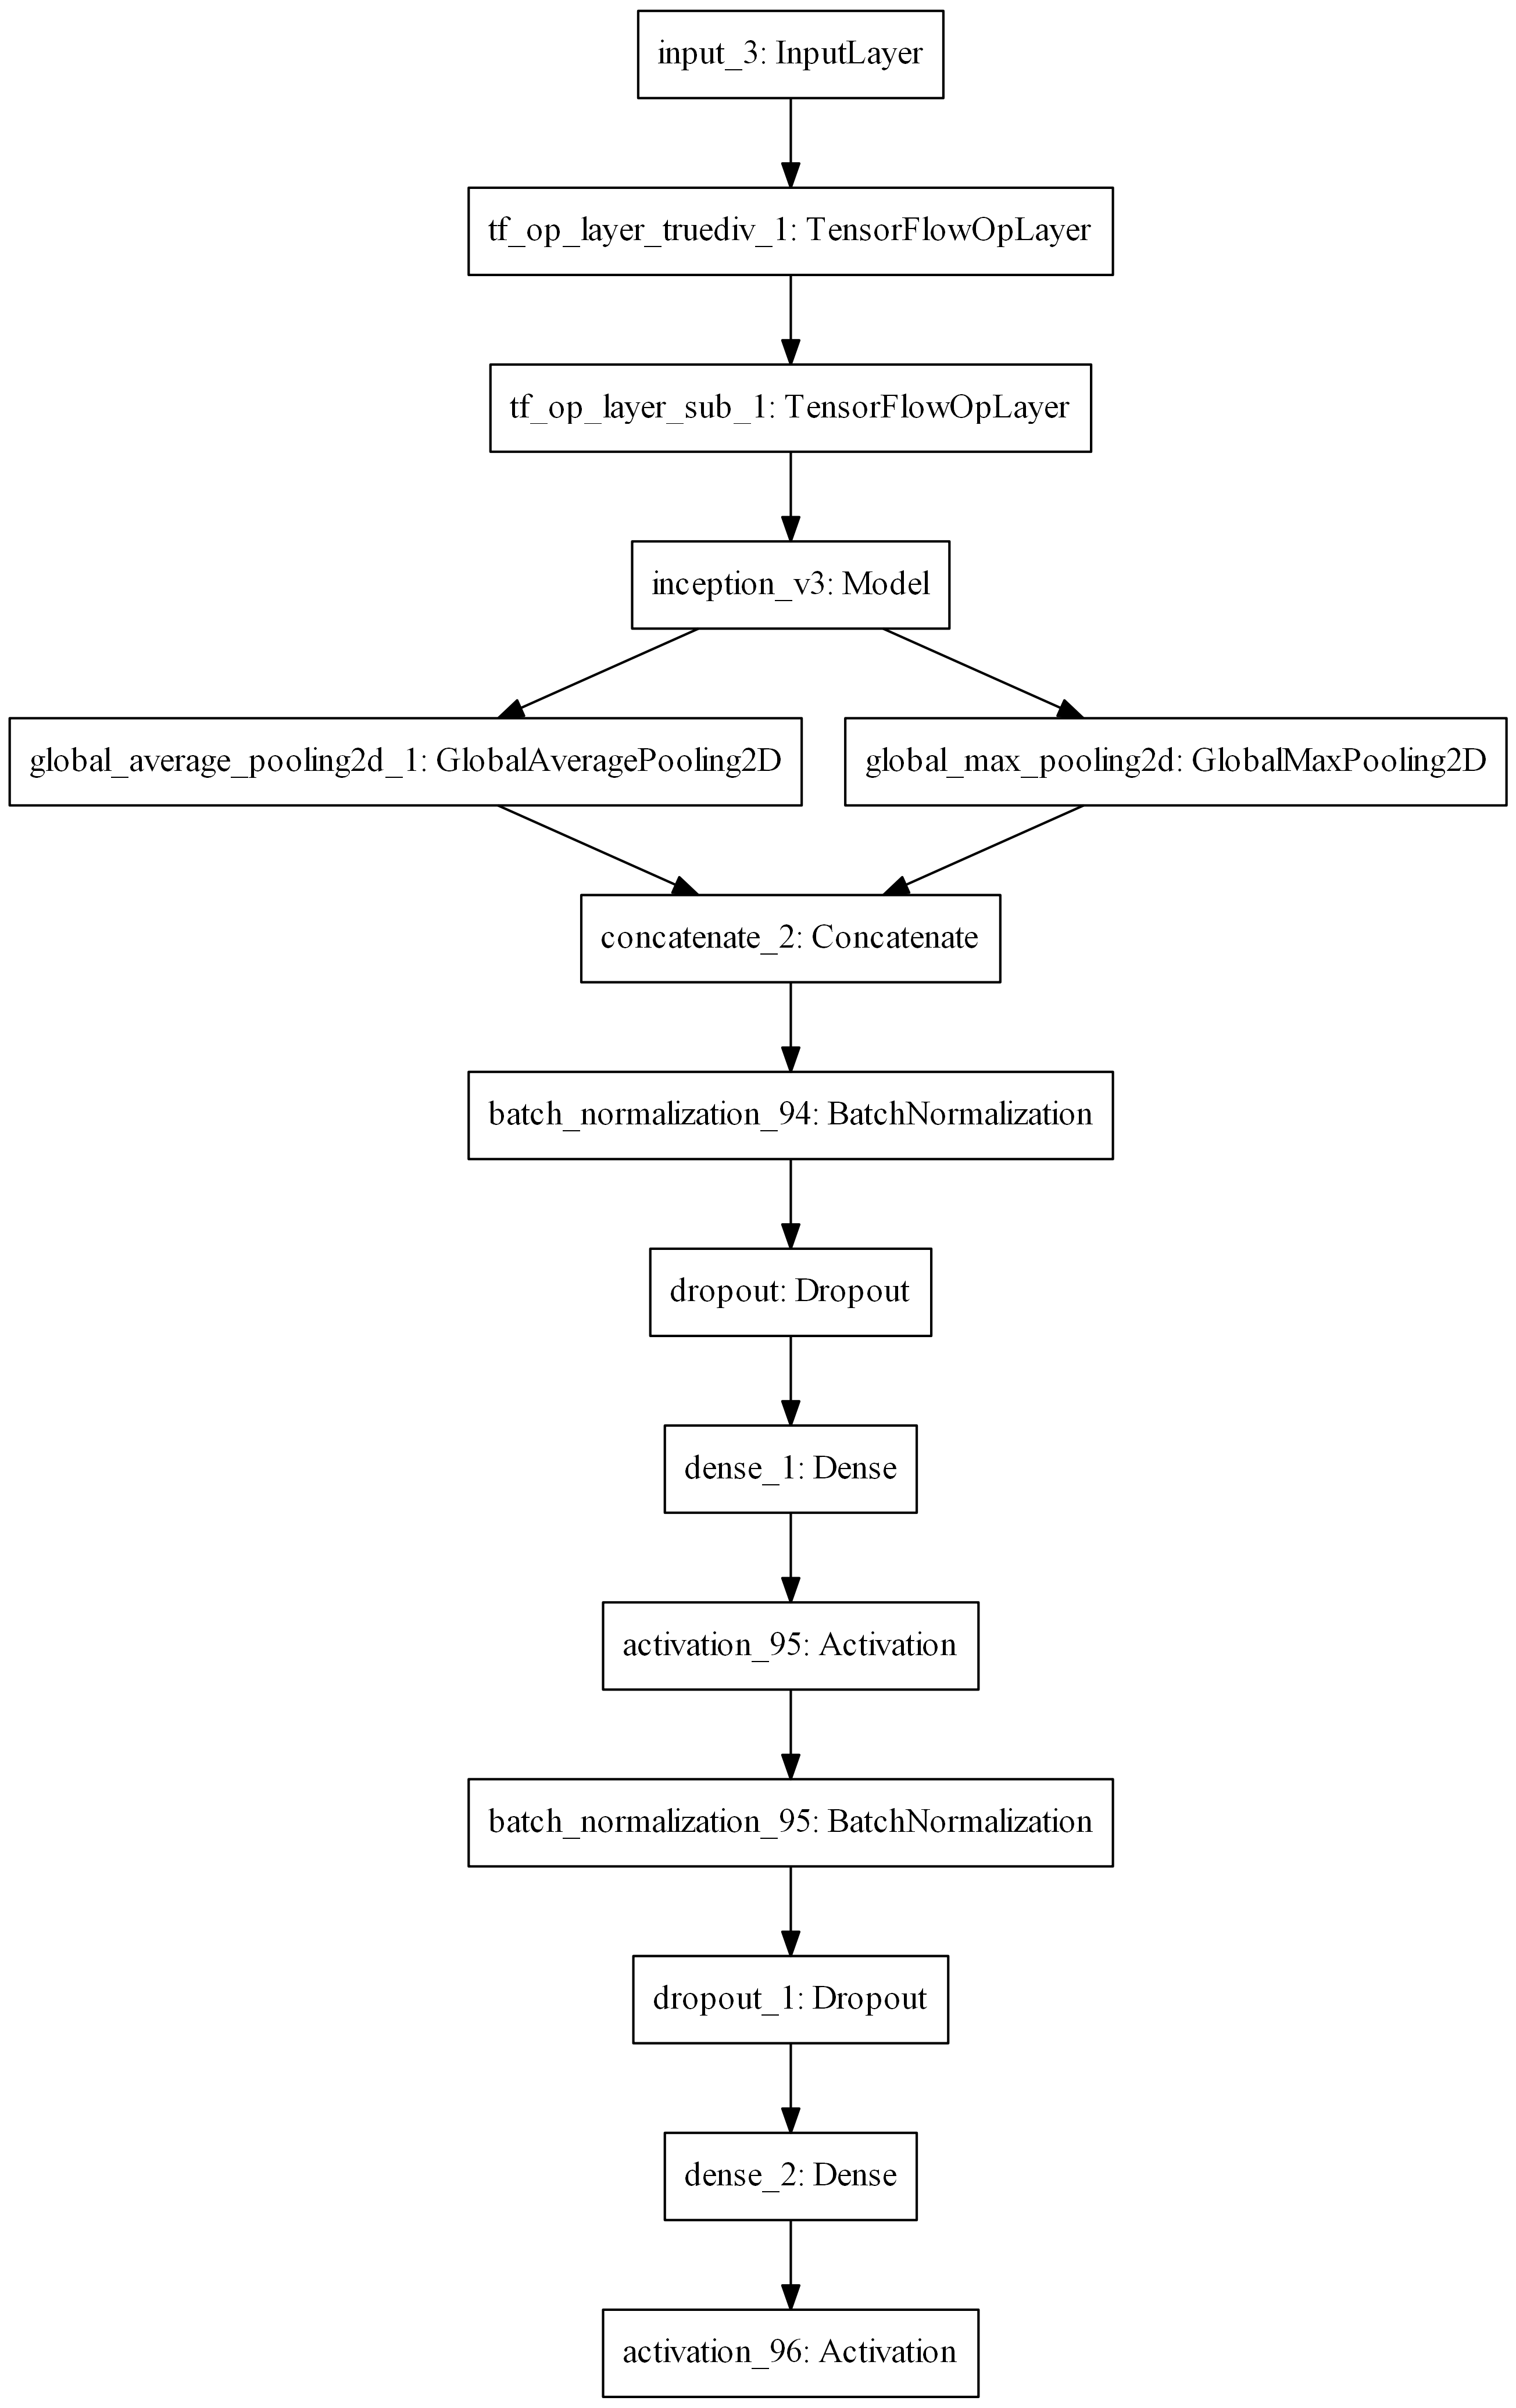

In [31]:
utils.plot_model(model, dpi=300)

In [32]:
history = model.fit(train_generator,
                    epochs=epoch,
                    validation_data=valid_generator,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/50
24/24 [==============================] - 51s 2s/step - loss: 2.2813 - categorical_accuracy: 0.3147 - val_loss: 1.6265 - val_categorical_accuracy: 0.3652
Epoch 2/50
24/24 [==============================] - 36s 2s/step - loss: 1.9361 - categorical_accuracy: 0.3947 - val_loss: 1.3710 - val_categorical_accuracy: 0.4348
Epoch 3/50
24/24 [==============================] - 37s 2s/step - loss: 1.8089 - categorical_accuracy: 0.4387 - val_loss: 1.3612 - val_categorical_accuracy: 0.4348
Epoch 4/50
24/24 [==============================] - 36s 1s/step - loss: 1.7991 - categorical_accuracy: 0.4493 - val_loss: 1.3612 - val_categorical_accuracy: 0.4435
Epoch 5/50
24/24 [==============================] - 36s 1s/step - loss: 1.6660 - categorical_accuracy: 0.4880 - val_loss: 1.2853 - val_categorical_accuracy: 0.4783
Epoch 6/50
24/24 [==============================] - 36s 1s/step - loss: 1.6042 - categori

In [33]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
4/4 [==============================] - 2s 422ms/step - loss: 1.2238 - categorical_accuracy: 0.5478


[1.2237820625305176, 0.5478261]

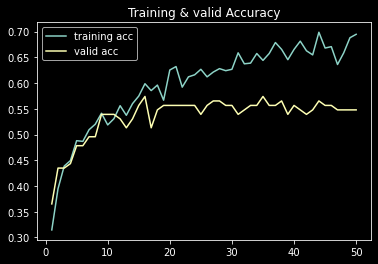

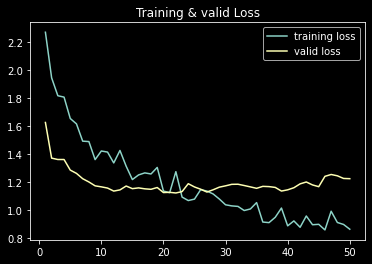

In [34]:
plot_training(history)

## Fast.ai Classifier Modified

Source: https://www.coursera.org/learn/deep-neural-network/lecture/RN8bN/fitting-batch-norm-into-a-neural-network


In [35]:
try:
    del (model)
except:
    pass

In [36]:
input_layer = keras.Input(shape=(image_shape))
x = preprocess_input(input_layer)
x = conv_base(x, training=False)
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([x1, x2])
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5)(x)
output_layer = layers.Activation("softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [37]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=lr_init),
              metrics=["categorical_accuracy"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

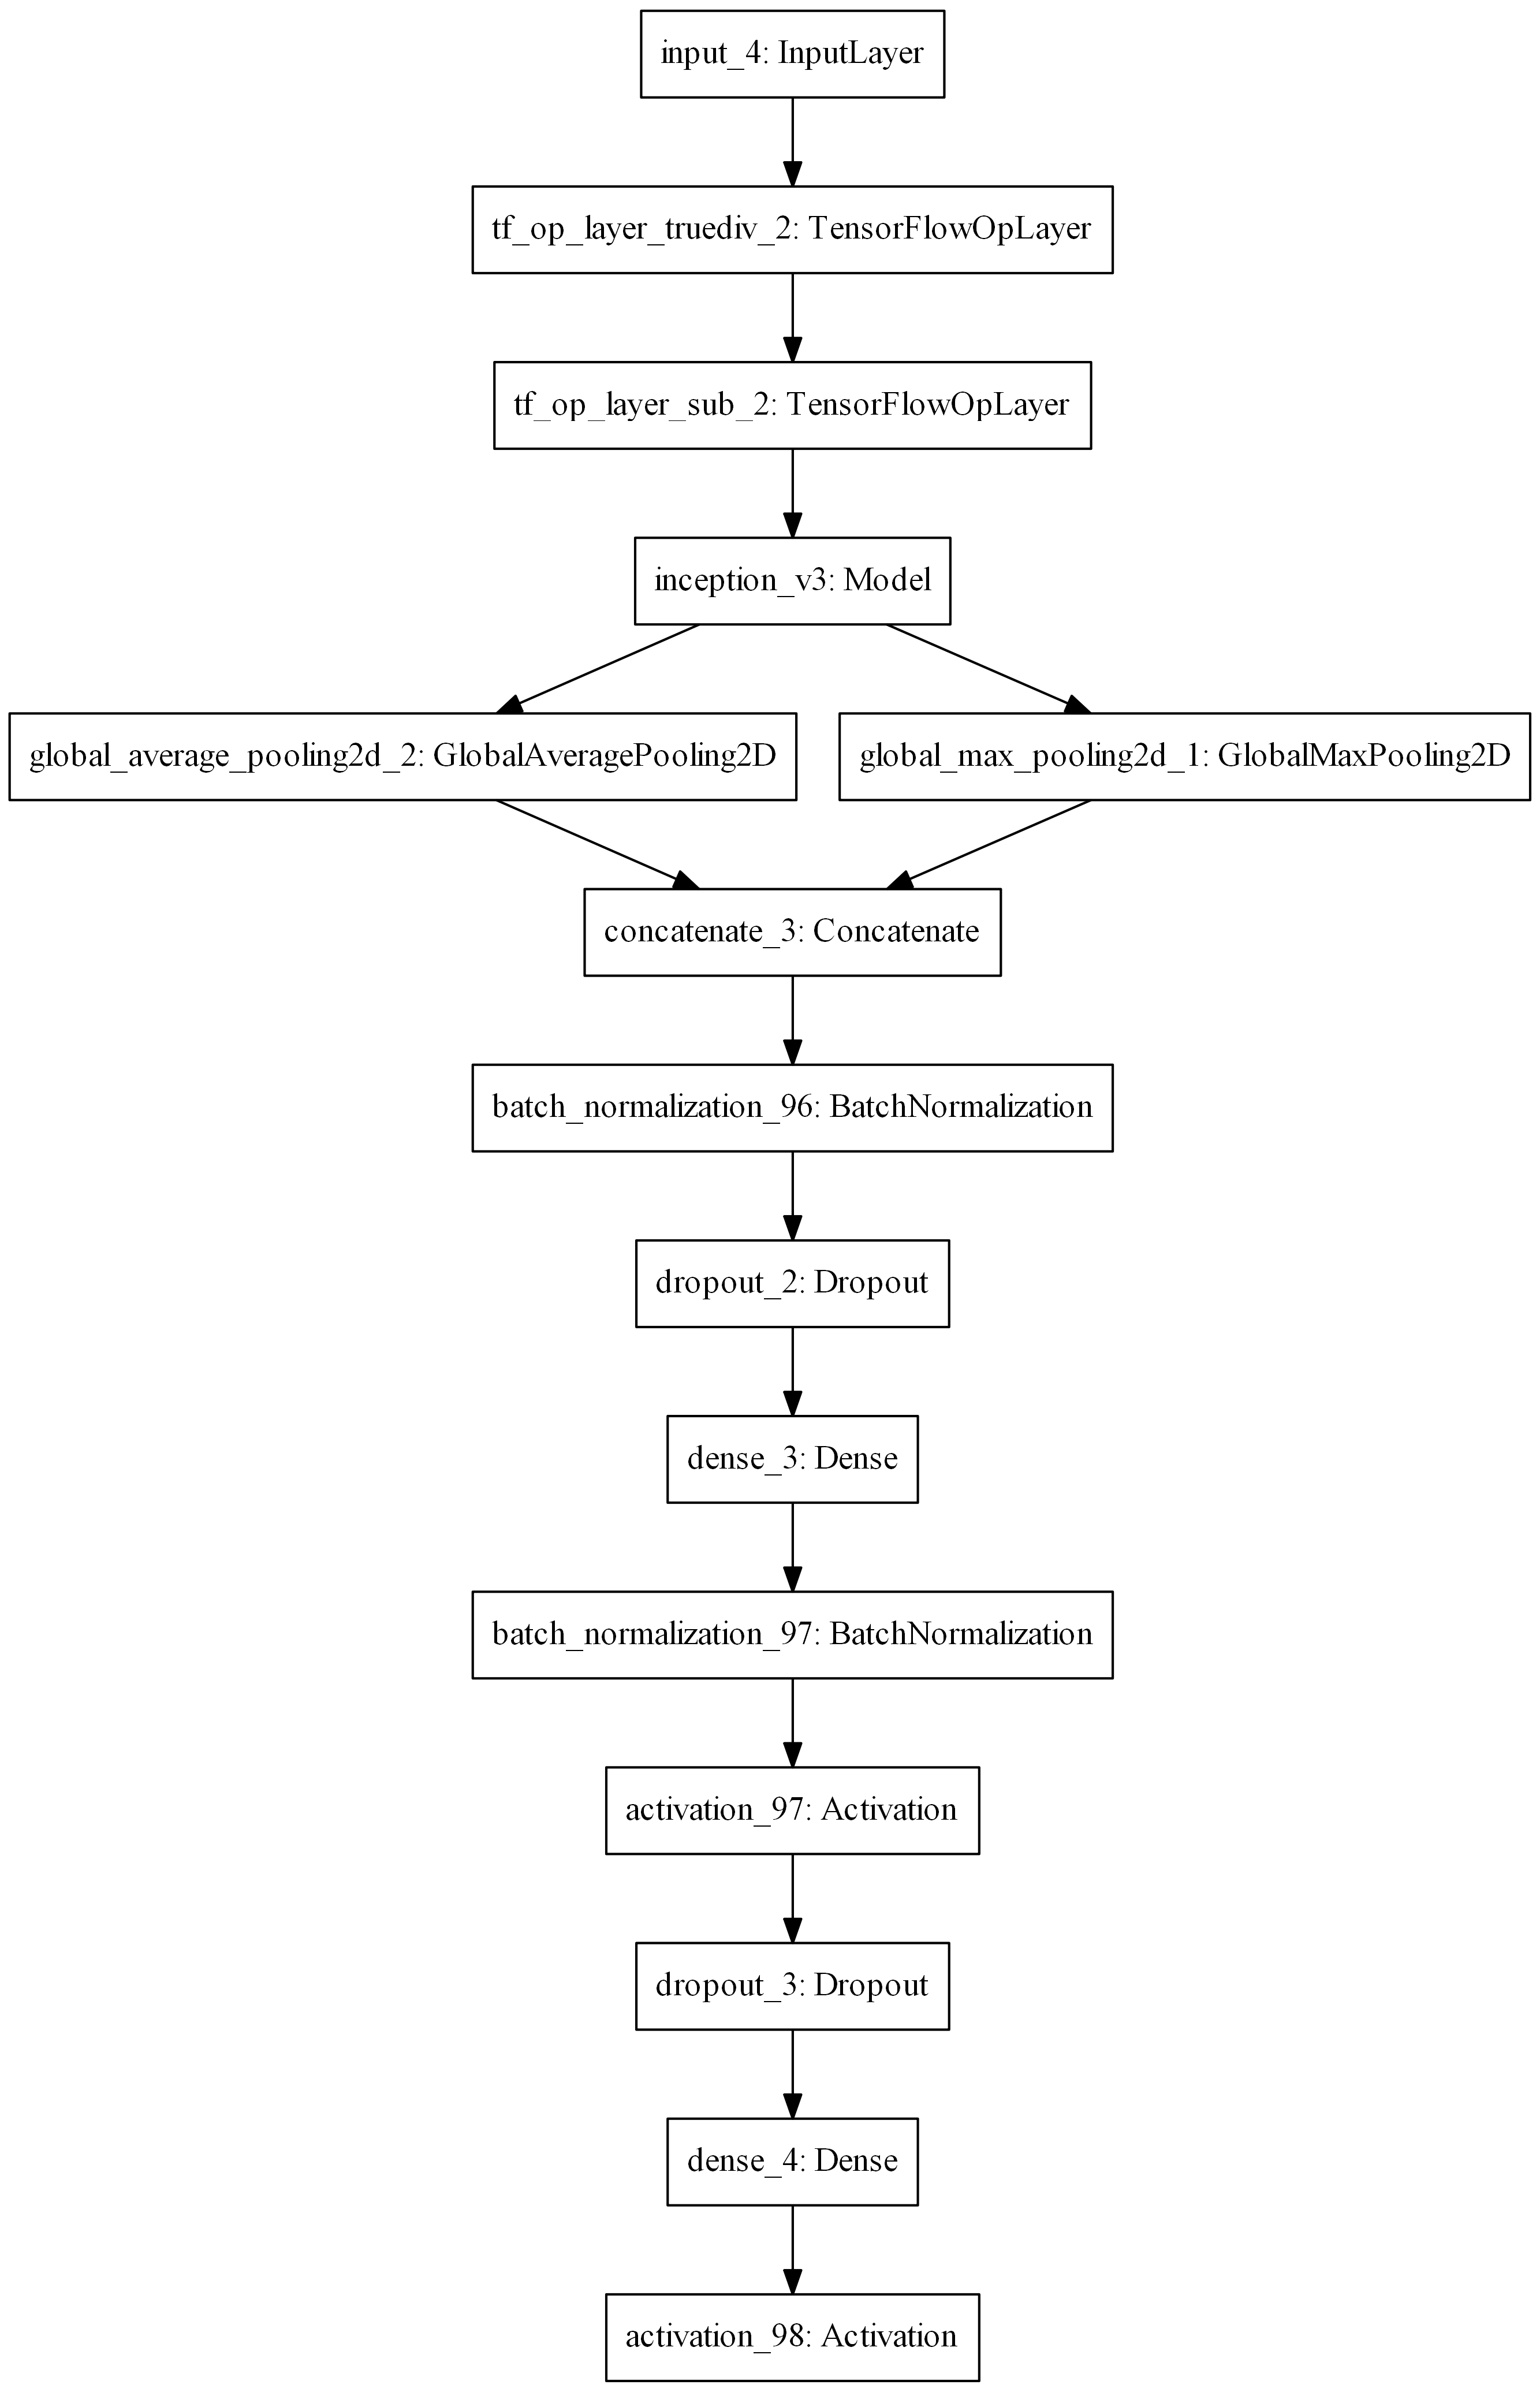

In [38]:
utils.plot_model(model, dpi=300)

In [39]:
history = model.fit(train_generator,
                    epochs=epoch,
                    validation_data=valid_generator,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/50
24/24 [==============================] - 48s 2s/step - loss: 1.9161 - categorical_accuracy: 0.3120 - val_loss: 2.3941 - val_categorical_accuracy: 0.2000
Epoch 2/50
24/24 [==============================] - 35s 1s/step - loss: 1.5982 - categorical_accuracy: 0.4093 - val_loss: 1.5524 - val_categorical_accuracy: 0.2435
Epoch 3/50
24/24 [==============================] - 36s 1s/step - loss: 1.5126 - categorical_accuracy: 0.4387 - val_loss: 1.4138 - val_categorical_accuracy: 0.3304
Epoch 4/50
24/24 [==============================] - 36s 1s/step - loss: 1.3913 - categorical_accuracy: 0.4893 - val_loss: 1.3355 - val_categorical_accuracy: 0.4087
Epoch 5/50
24/24 [==============================] - 35s 1s/step - loss: 1.3155 - categorical_accuracy: 0.5173 - val_loss: 1.2690 - val_categorical_accuracy: 0.4261
Epoch 6/50
24/24 [==============================] - 35s 1s/step - loss: 1.2945 - categori

In [40]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
4/4 [==============================] - 2s 596ms/step - loss: 1.0416 - categorical_accuracy: 0.6261


[1.041573852300644, 0.62608695]

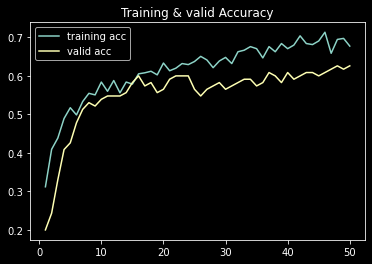

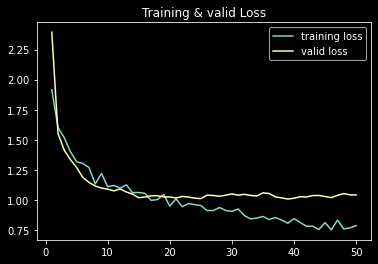

In [41]:
plot_training(history)